<h1 align="center">Eye Diseases Classification 👁️</h1>
<p style="text-align:center;">The dataset consists of Normal, Diabetic Retinopathy, Cataract, and Glaucoma retinal images, where each class has approximately 1000 images. These images are collected from kaggle.</p>

## Imports

In [33]:
!pip install seaborn
!pip install torchmetrics

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from torchmetrics import Accuracy, ConfusionMatrix, Precision, Recall, F1Score

from tqdm import tqdm


## Load data

In [35]:
def load_data():
    t = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((256, 256)),
        ]
    )

    return datasets.ImageFolder(root="dataset", transform=t)


In [36]:
dataset = load_data()


In [37]:
dataset


Dataset ImageFolder
    Number of datapoints: 4217
    Root location: dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
           )

In [38]:
# number of classes
NUMBER_OF_CLASSES = len(set(dataset.targets))


In [39]:
print(f"Number of classes: {NUMBER_OF_CLASSES}")


Number of classes: 4


### Exploring images

Label : cataract


c:\Users\anupm\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


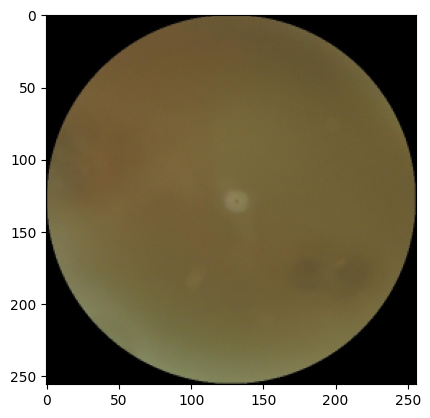

In [40]:
def display_image(image, label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(image.permute(1, 2, 0))


# display the first image in the dataset
display_image(*dataset[0])


## Split data into train-test

In [41]:
def train_test_split(dataset, train_size, random_state=42):
    train_size = int(train_size * len(dataset))
    test_size = len(dataset) - train_size
    seed = torch.Generator().manual_seed(random_state)
    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, test_size], generator=seed
    )

    return train_dataset, test_dataset


In [42]:
train_dataset, test_dataset = train_test_split(dataset, 0.8)


## DataLoader

In [43]:
batch_size = 32
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)


### Visualizing the batch images

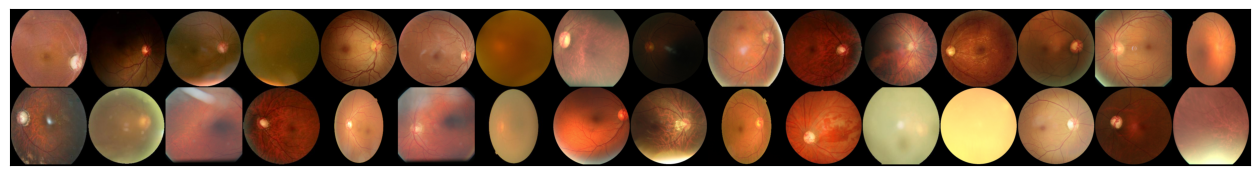

In [44]:
def show_batch(data_loader):
    """Plot images grid of single batch"""
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


show_batch(train_dataloader)


## Convolutional neural network (CNN)

In [45]:
class CNN(nn.Module):
    def __init__(self, NUMBER_OF_CLASSES):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(64 * 3 * 3, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, NUMBER_OF_CLASSES),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.dense_layers(x)

        return x


In [46]:
model = CNN(NUMBER_OF_CLASSES)


In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


## Device configuration

In [48]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.backends.mps.is_available():
    device = "mps"


## Training function

In [49]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):

    model.to(device)
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    accuracy = Accuracy(task="multiclass",
                        num_classes=NUMBER_OF_CLASSES).to(device)
    for epoch in range(epochs):
        train_loss = []
        for inputs, targets in tqdm(train_loader, desc=f'Training... Epoch: {epoch + 1}/{epochs}'):
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Get train loss
        train_loss = np.mean(train_loss)
        # Train accuracy
        train_accuracy = accuracy(outputs, targets)

        test_loss = []
        for inputs, targets in tqdm(test_loader, desc=f'Validating... Epoch: {epoch + 1}/{epochs}'):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss.append(loss.item())

        # Get test loss
        test_loss = np.mean(test_loss)
        # Test accuracy
        test_accuracy = accuracy(outputs, targets)

        # Save losses
        train_losses[epoch] = train_loss
        test_losses[epoch] = test_loss

        print(f"Epoch {epoch+1}/{epochs}:")
        print(
            f"Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}")
        print(
            f"Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")
        print('-'*30)

    return train_losses, test_losses


In [50]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_dataloader, test_dataloader, epochs=10
)


Validating... Epoch: 1/10: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s]


Epoch 1/10:
Train Loss: 0.93, Train Accuracy: 0.62
Test Loss: 0.73, Test Accuracy: 0.83
------------------------------


Validating... Epoch: 2/10: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Epoch 2/10:
Train Loss: 0.59, Train Accuracy: 0.92
Test Loss: 0.48, Test Accuracy: 0.83
------------------------------


Validating... Epoch: 3/10: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 3/10:
Train Loss: 0.54, Train Accuracy: 0.69
Test Loss: 0.54, Test Accuracy: 0.83
------------------------------


Validating... Epoch: 4/10: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]


Epoch 4/10:
Train Loss: 0.45, Train Accuracy: 0.69
Test Loss: 0.44, Test Accuracy: 0.92
------------------------------


Validating... Epoch: 5/10: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


Epoch 5/10:
Train Loss: 0.41, Train Accuracy: 0.85
Test Loss: 0.44, Test Accuracy: 0.92
------------------------------


Validating... Epoch: 6/10: 100%|██████████| 27/27 [00:20<00:00,  1.29it/s]


Epoch 6/10:
Train Loss: 0.39, Train Accuracy: 0.92
Test Loss: 0.39, Test Accuracy: 0.92
------------------------------


Validating... Epoch: 7/10: 100%|██████████| 27/27 [00:20<00:00,  1.33it/s]


Epoch 7/10:
Train Loss: 0.37, Train Accuracy: 0.77
Test Loss: 0.39, Test Accuracy: 1.00
------------------------------


Validating... Epoch: 8/10: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


Epoch 8/10:
Train Loss: 0.36, Train Accuracy: 0.85
Test Loss: 0.39, Test Accuracy: 1.00
------------------------------


Validating... Epoch: 9/10: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


Epoch 9/10:
Train Loss: 0.32, Train Accuracy: 0.77
Test Loss: 0.50, Test Accuracy: 1.00
------------------------------


Validating... Epoch: 10/10: 100%|██████████| 27/27 [00:20<00:00,  1.33it/s]

Epoch 10/10:
Train Loss: 0.32, Train Accuracy: 0.85
Test Loss: 0.40, Test Accuracy: 0.92
------------------------------


## Plot the losses

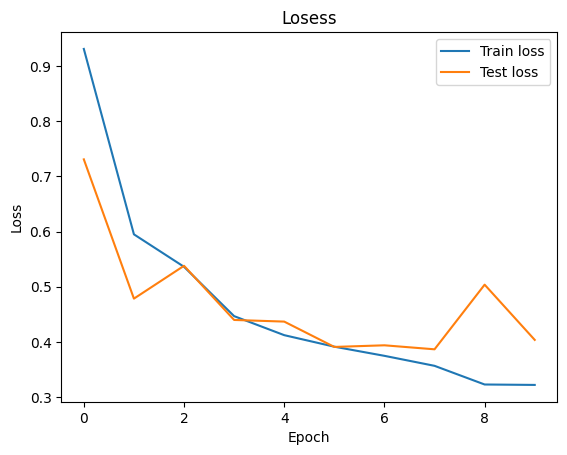

In [51]:
plt.title("Losess")
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


## Predection

In [52]:
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predections = torch.max(outputs, 1)

        y_pred_list.append(targets.cpu().numpy())
        y_true_list.append(predections.cpu().numpy())

targets = torch.tensor(np.concatenate(y_true_list))
preds = torch.tensor(np.concatenate(y_pred_list))


## Evaluations

### Confusion matrix

In [53]:
confmat = ConfusionMatrix(task="multiclass", num_classes=NUMBER_OF_CLASSES)
cm = confmat(preds, targets)


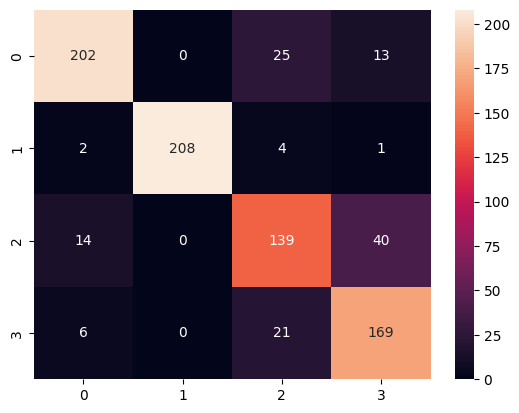

In [54]:
sn.heatmap(cm, annot=True, fmt=".0f")
plt.show()


### Accuracy

In [55]:
accuracy = Accuracy(task="multiclass", num_classes=NUMBER_OF_CLASSES).to(device)
accuracy = accuracy(preds, targets)
print(f"Accuracy: {100 * accuracy:.2f}%")


Accuracy: 85.07%


### Precision

In [56]:
precision = Precision(task="multiclass", average='micro', num_classes=NUMBER_OF_CLASSES)
precision = precision(preds, targets)
print(f"Precision: {100 * precision:.2f}%")

Precision: 85.07%


### Recall

In [57]:
recall = Recall(task="multiclass", average='micro', num_classes=NUMBER_OF_CLASSES)
recall = recall(preds, targets)
print(f"Recall: {100 * recall:.2f}%")

Recall: 85.07%


### F1-score

In [58]:
f1 = F1Score(task="multiclass", num_classes=NUMBER_OF_CLASSES)
f1 = f1(preds, targets)
print(f"F1 Score: {100 * f1:.2f}%")

F1 Score: 85.07%


In [59]:
import pickle

In [60]:
with open('eye_detection_model.pkl', 'wb') as f:
    pickle.dump(model, f)  # Replace 'model' with your actual model variable name
print("Model saved successfully!")

Model saved successfully!
